# Minute Wise Traffic Prediction Using FbProphet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook, we will be focusing on predicting minute wise prediction of the number of traffic. We will be using FbProphet, which is a pretty fast time series forecasting algorithm made by  Facebook Team. We will also have a look the **time required** so that we can have a comparison of it with the same dataset for different other models like LSTM, SARIMA etc ( which we will be doing later on in another notebook). So, lets start.

# Importing Libraries

First, we will start by importing necessary libraries for the task. For those who did not install fbprophet can simple do it by **pip install fbprophet** in their terminal. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fbprophet as Prophet
from sklearn.metrics import mean_squared_error,r2_score
import math
import time
%matplotlib inline

# Dataset

The Dataset used here contains the traffic count of a certain road at each 5 minutes interval. There are two columns in the dataset, one is the timestamp and another is the hourly traffic count (which is actually counted in each five minutes interval.

In [2]:
df = pd.read_csv('../input/traffic/DataSet/train27303.csv')

In [3]:
df.head()

,timestamp,hourly_traffic_count
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,16
2,2015-10-04 00:10:00,9
3,2015-10-04 00:15:00,12
4,2015-10-04 00:20:00,19


In [4]:
df.tail()

,timestamp,hourly_traffic_count
26491,2016-01-03 23:35:00,16
26492,2016-01-03 23:40:00,15
26493,2016-01-03 23:45:00,10
26494,2016-01-03 23:50:00,19
26495,2016-01-03 23:55:00,15


In [5]:
df.shape

(26496, 2)

As you can see, the dataset contains 26396 rows of data starting from **2015-10-04 00:00:00** and which ends at **2016-01-03 23:55:00** . At each day, with a 5 minutes interval, the traffic is counted. So, for each day, we get 24x60/5 = 288 rows or timestamps of traffic data.

# Visualizing the Dataset

Now, lets plot the traffic data and observe the dataset with a visualization.

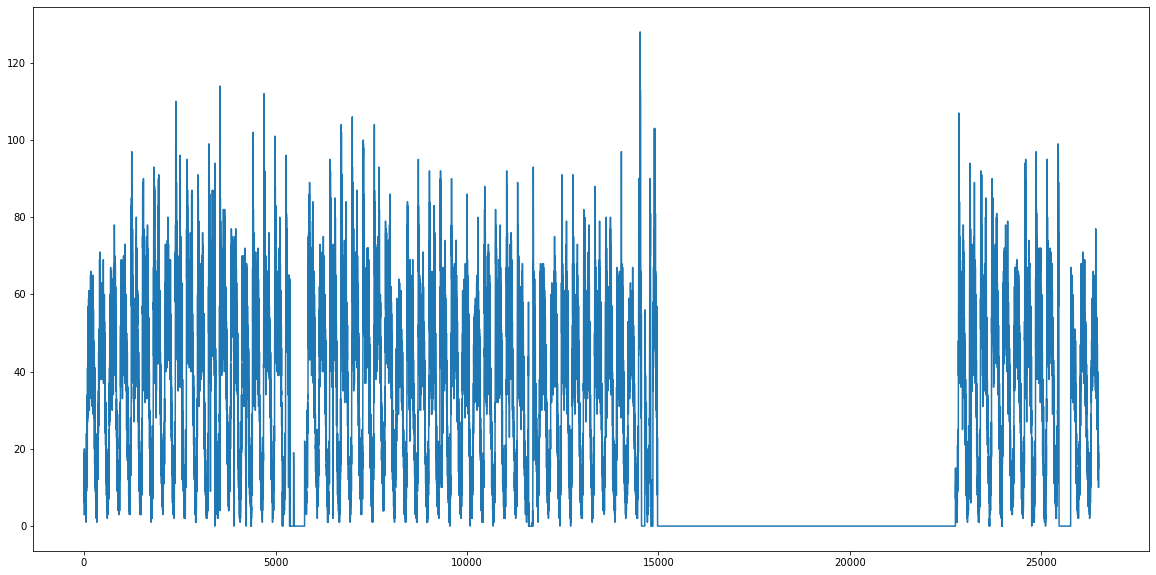

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df['hourly_traffic_count'])
plt.show()

As you can see above, the dataset is seasonal, that means it has a repeating pattern to it. Thats a good thing. But the problem here is it has missing values, but they are not NaN, they are zero(0). This missing value is because the dataset was created using machine which eventually ran into some error. Thats why the machine could not count traffic. Hence it placed zero at those place. 

There are a several approach to handle those missing value. But for simplicity sake, we are going to exclude the values with error. 

To be more specific, we will be using only a month's data starting from **2015-10-04 00:00:00** to **2015-11-03 00:00:00** for training purpose (31days x 288 rows each day = 8928 timestamps) and will try to predict the next 3 days traffic (3x288 = 864 timestamp) for testing purpose. So, in total we are going to extract 9792 timestamps or rows from our dataset and get a visualization.

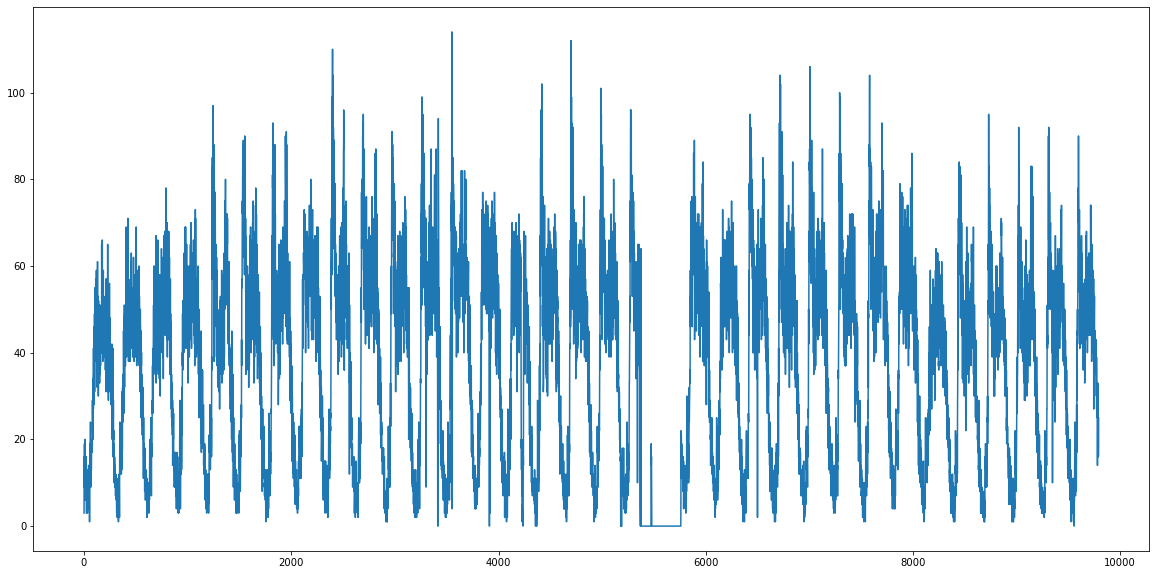

In [7]:
df = df.iloc[:9792,:]

plt.figure(figsize=(20,10))
plt.plot(df['hourly_traffic_count'])
plt.show()

So, from the above visualizaton, we have seen that the errors are almost excluded. So now our dataset is ready. We will do some preprocessing of the data. This is because **FbProphet** needs the dataset to have two columns in specific names: **ds** and **y**. Also the ds column needs to be in datetime format. So, we will check and tune our dataset accordingly. 

In [8]:
df = df.rename(columns = {'timestamp':'ds','hourly_traffic_count':'y'})
df.dtypes

ds    object
y      int64
dtype: object

In [9]:
df['ds'] = pd.to_datetime(df['ds'])
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [10]:
df

,ds,y
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,16
2,2015-10-04 00:10:00,9
3,2015-10-04 00:15:00,12
4,2015-10-04 00:20:00,19
...,...,...
9787,2015-11-06 23:35:00,23
9788,2015-11-06 23:40:00,25
9789,2015-11-06 23:45:00,16
9790,2015-11-06 23:50:00,18


# Train Test Split

As we have decided earlier, we will be using only a month's data starting from **2015-10-04 00:00:00** to **2015-11-03 00:00:00** for training purpose (31days x 288 rows each day = 8928 timestamps) and will try to predict the next 3 days traffic (3x288 = 864 timestamp) for testing purpose.

In [11]:
train_df = df.iloc[:8928,:]
test_df = df.iloc[8928:,:]

In [12]:
train_df

,ds,y
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,16
2,2015-10-04 00:10:00,9
3,2015-10-04 00:15:00,12
4,2015-10-04 00:20:00,19
...,...,...
8923,2015-11-03 23:35:00,17
8924,2015-11-03 23:40:00,12
8925,2015-11-03 23:45:00,13
8926,2015-11-03 23:50:00,5


In [13]:
test_df

,ds,y
8928,2015-11-04 00:00:00,13
8929,2015-11-04 00:05:00,11
8930,2015-11-04 00:10:00,18
8931,2015-11-04 00:15:00,16
8932,2015-11-04 00:20:00,16
...,...,...
9787,2015-11-06 23:35:00,23
9788,2015-11-06 23:40:00,25
9789,2015-11-06 23:45:00,16
9790,2015-11-06 23:50:00,18


# Creating our Prophet Model and Fitting Dataset

This is the main section of this notebook. We are going to create a model by calling Prophet. But as the core purpose of FbProphet was to deal data in day, month and year basis, so we need to add a parameter **changepoint_prior_scale=0.01** which will help us handle minute wise data for the model. Also we will calculate the time required for fitting the data with our model. We will use the python Time module to calculate the time. 

In [14]:
start = time.time()

m = Prophet.Prophet(changepoint_prior_scale=0.01)
m.fit(train_df)

end = time.time()
print('Time Required :', end-start,'seconds')

Time Required : 5.280515193939209 seconds


# Predicting the Future 3 Days

Now, we will predict the outcome for the next three days. For this, we need a matrix of the timestamps for which out model will predict the traffic count. So, for that, we used the ds column of our test_df and used the predict method to predict the outcome.

In [15]:
test = test_df.iloc[:,0:1]
fcst = m.predict(test)

In [16]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-11-04 00:00:00,35.646059,-1.955816,29.038002,35.646059,35.646059,-21.350083,-21.350083,-21.350083,-22.042922,-22.042922,-22.042922,0.692839,0.692839,0.692839,0.0,0.0,0.0,14.295976
1,2015-11-04 00:05:00,35.643262,-2.564593,30.488355,35.643262,35.643262,-21.636079,-21.636079,-21.636079,-22.334092,-22.334092,-22.334092,0.698013,0.698013,0.698013,0.0,0.0,0.0,14.007183
2,2015-11-04 00:10:00,35.640464,-2.065774,29.514137,35.640464,35.640464,-21.903758,-21.903758,-21.903758,-22.607086,-22.607086,-22.607086,0.703328,0.703328,0.703328,0.0,0.0,0.0,13.736706
3,2015-11-04 00:15:00,35.637667,-2.401318,29.234846,35.637667,35.637667,-22.154995,-22.154995,-22.154995,-22.863777,-22.863777,-22.863777,0.708782,0.708782,0.708782,0.0,0.0,0.0,13.482672
4,2015-11-04 00:20:00,35.634869,-2.740642,28.802302,35.634869,35.634869,-22.391742,-22.391742,-22.391742,-23.106118,-23.106118,-23.106118,0.714375,0.714375,0.714375,0.0,0.0,0.0,13.243127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,2015-11-06 23:35:00,33.242992,-5.487165,27.753652,31.411540,35.263080,-21.982221,-21.982221,-21.982221,-20.256341,-20.256341,-20.256341,-1.725879,-1.725879,-1.725879,0.0,0.0,0.0,11.260771
860,2015-11-06 23:40:00,33.240194,-3.923770,27.836826,31.404965,35.269180,-22.347512,-22.347512,-22.347512,-20.662626,-20.662626,-20.662626,-1.684886,-1.684886,-1.684886,0.0,0.0,0.0,10.892682
861,2015-11-06 23:45:00,33.237397,-5.936513,27.094522,31.398544,35.275955,-22.687031,-22.687031,-22.687031,-21.043112,-21.043112,-21.043112,-1.643919,-1.643919,-1.643919,0.0,0.0,0.0,10.550365
862,2015-11-06 23:50:00,33.234599,-5.696954,26.184614,31.392263,35.282731,-23.002017,-23.002017,-23.002017,-21.399036,-21.399036,-21.399036,-1.602981,-1.602981,-1.602981,0.0,0.0,0.0,10.232582


# Visulatization of the Prediction

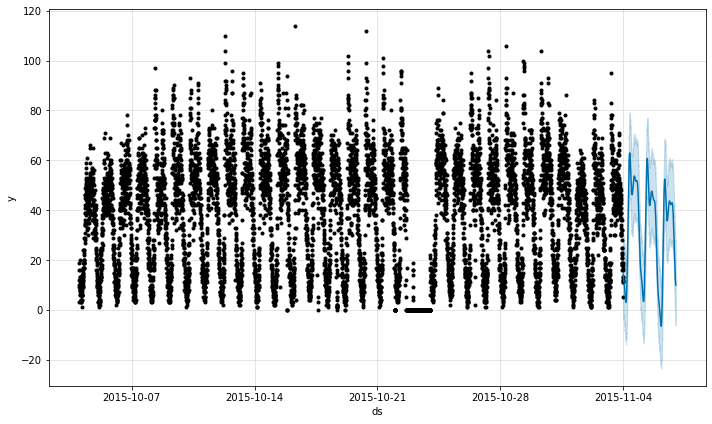

In [17]:
fig = m.plot(fcst)

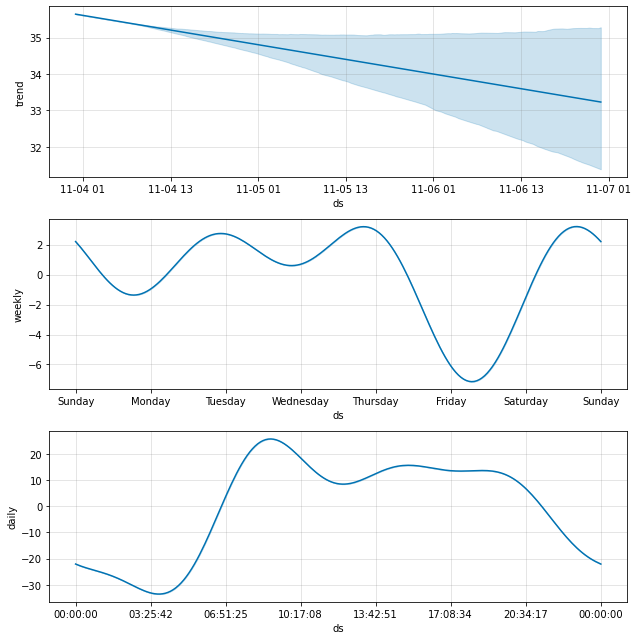

In [18]:
fig2 = m.plot_components(fcst)

Lets compare the Actual Test results with the predicted result.

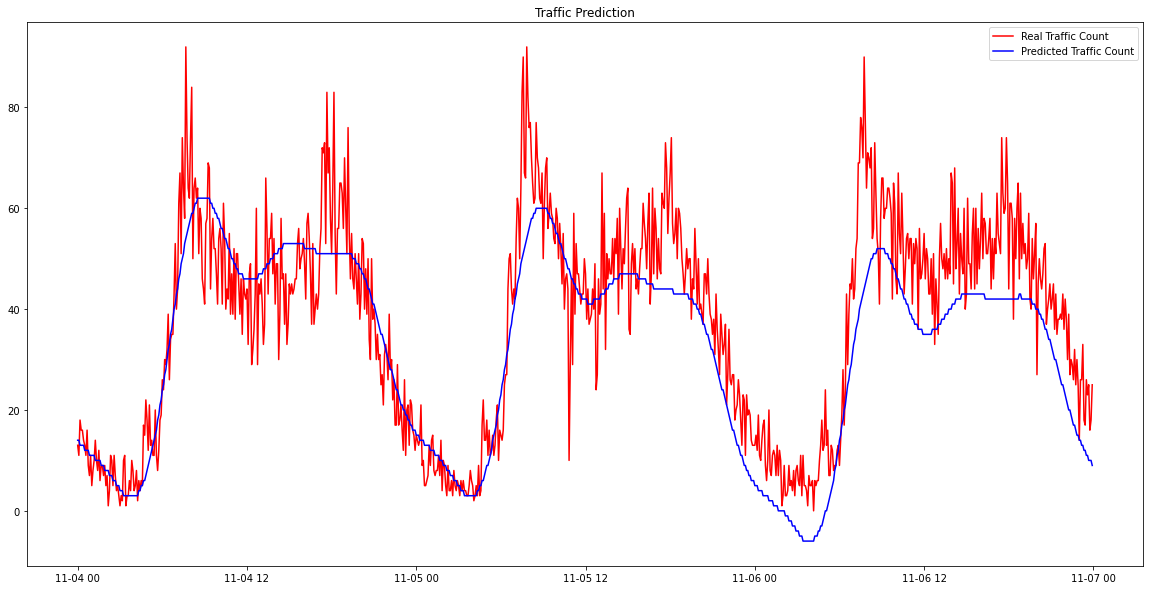

In [19]:
plt.figure(figsize=(20,10))
plt.plot(test_df['ds'],test_df['y'], color = 'red', label = 'Real Traffic Count')
plt.plot(fcst['ds'],fcst['yhat'].astype(int), color = 'blue', label = 'Predicted Traffic Count')
plt.title('Traffic Prediction')
plt.legend()
plt.show()

# Evaluation & Accuracy


In [20]:
output = test_df.copy()
output['y_pred'] = fcst['yhat'].values.astype(int)
output

,ds,y,y_pred
8928,2015-11-04 00:00:00,13,14
8929,2015-11-04 00:05:00,11,14
8930,2015-11-04 00:10:00,18,13
8931,2015-11-04 00:15:00,16,13
8932,2015-11-04 00:20:00,16,13
...,...,...,...
9787,2015-11-06 23:35:00,23,11
9788,2015-11-06 23:40:00,25,10
9789,2015-11-06 23:45:00,16,10
9790,2015-11-06 23:50:00,18,10


In [21]:
output.to_csv('./output.csv',index=False)

In [22]:
rmse = math.sqrt(mean_squared_error(test_df['y'],fcst['yhat'].astype(int)))
print("Root Mean Squared Error :",rmse)
r_sq = r2_score(test_df['y'],fcst['yhat'].astype(int))
print("R Squared Score :",r_sq)
print('Time Required :', end-start,'seconds')

Root Mean Squared Error : 10.942188148696836
R Squared Score : 0.726864056730185
Time Required : 5.280515193939209 seconds


# Conclusion

We have successfully implemented **FbProphet** time series forecasting tool at a minute level dataset and we have got a good score. We can improve the score if we have more amount of data. The FbProphet was successful to capture the pattern, trend and also it showed the seasonal pattern and possible outcome. The  most amazing thing is its timing. It took only a few seconds to fit the data and created such an astonishing result. So, if time is a factor for any purpose, fbprophet is surely a must tool for any time series prediction.